In [1]:
import os
import tarfile
import urllib.request

import albumentations as albu
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils
import torch
import torch.utils.data as data
from PIL import Image

In [2]:
%cd /work

/work


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
# 使用データのDL
data_dir = "./GSI_Dataset/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

url = "https://gisstar.gsi.go.jp/gsi-dataset/02/H1-No17-286.tar.gz"
target_path = os.path.join(data_dir, "H1-No17-286.tar.gz") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    with tarfile.open(target_path, 'r:gz') as tar:
        tar.extractall(data_dir)

In [4]:
def get_augmentation(phase):
    if phase == "train":
        train_transform = [
            albu.HorizontalFlip(p=0.5),
            albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
            albu.RandomBrightnessContrast()
        ]
        return albu.Compose(train_transform)

    if phase=="valid":
        return None

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype("float32")

def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def crop_to_square(image):
    size = min(image.size)
    left, upper = (image.width - size) // 2, (image.height - size) // 2
    right, bottom = (image.width + size) // 2, (image.height + size) // 2
    return image.crop((left, upper, right, bottom))

In [5]:
class GSIDataset(data.Dataset):

    # VOCデータセットのクラス名
    # http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/index.html
    CLASSES = ["background","road"]

    def __init__(self, images_path, masks_path, segment_class, 
                 augmentation=None, preprocessing=None):

        self.images_path = images_path
        self.masks_path = masks_path
        self.segment_class = segment_class
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, i):

        # 元画像・マスク画像を読み込み、差分からOne hotベクトルを作成する
        image = Image.open(self.images_path[i])
        #image = crop_to_square(image)
        image = np.asarray(image)

        masks = Image.open(self.masks_path[i])
        #masks = crop_to_square(masks)
        masks = np.asarray(masks)

        diff = Image.fromarray(masks - image)
        diff = diff.resize((128,128), Image.Resampling.LANCZOS)
        diff = np.asarray(diff)

        image = Image.fromarray(image)
        image = image.resize((128,128), Image.Resampling.LANCZOS)
        image = np.asarray(image)

        idx = np.zeros(image.shape[:2], dtype = np.uint8 ) 
        idx[np.any(diff != 0, axis=-1)] = 1

        num_classes = 2
        mask = np.eye(num_classes)[idx]

        # augmentationの実行
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # 前処理の実行
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

In [6]:
# モデルの各種設定
ENCODER = "efficientnet-b4"
ENCODER_WEIGHTS = "imagenet"
ACTIVATION = "softmax2d"
PREDICT_CLASS = ["background","road"]
DEVICE = "cuda"
BATCH_SIZE = 64

# Unet++でモデル作成
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(PREDICT_CLASS), 
    activation=ACTIVATION,
)

In [7]:
import random

def split_dataset(file_paths, train_ratio=0.8, seed=None):
    """
    ファイルパスのリストを学習用と評価用に分離する関数。
    
    Args:
        file_paths (list): ファイルパスのリスト。
        train_ratio (float): 学習データの割合（0〜1の範囲, デフォルト: 0.8）。
        seed (int): ランダムシード（デフォルト: None）。
    
    Returns:
        tuple: 学習用リスト, 評価用リスト
    """
    if seed is not None:
        random.seed(seed)  # 再現性のためシードを固定

    # シャッフル
    shuffled_paths = file_paths.copy()
    random.shuffle(shuffled_paths)

    # 分割点を計算
    split_idx = int(len(shuffled_paths) * train_ratio)

    # 学習用と評価用に分割
    train_paths = shuffled_paths[:split_idx]
    eval_paths = shuffled_paths[split_idx:]

    return train_paths, eval_paths

In [8]:
import glob

# encoderに合わせた前処理の取得
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# データ周りを格納する辞書
data_info = {}
rootpath = r"/work/GSI_Dataset/org286"

file_paths = glob.glob( os.path.join(rootpath, '*.png') )
train_paths, eval_paths = split_dataset(file_paths, train_ratio=0.8, seed=None)

images_path = {} 
images_path['train'] = train_paths
images_path['val'] = eval_paths

masks_path = {}
masks_path['train'] = [ path.replace('org286', 'val286') for path in train_paths]
masks_path['val']   = [ path.replace('org286', 'val286') for path in eval_paths]

for phase in ["train", "val"]:
    # 画像のpath
    data_info[f"{phase}_img_path"] = images_path[f"{phase}"]
    data_info[f"{phase}_mask_path"] = masks_path[f"{phase}"]

    # Dataset
    data_info[f"{phase}_dataset"] = GSIDataset(
            data_info[f"{phase}_img_path"], 
            data_info[f"{phase}_mask_path"], 
            segment_class=PREDICT_CLASS,
            augmentation=get_augmentation(phase), 
            preprocessing=get_preprocessing(preprocessing_fn)
            )

    # DataLoader
    shuffle = True if phase=="train" else False
    data_info[f"{phase}_dataloader"] = data.DataLoader(
        data_info[f"{phase}_dataset"], 
        batch_size=BATCH_SIZE, 
        shuffle=shuffle)

In [9]:
# 学習時の各種設定
loss = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])

train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE
)

In [10]:
patience = 5 # 5Epcoch以上連続でモデル精度が向上しなければEarly Stopping

max_score = 0
for i in range(50):
    
    print(f"Epoch:{i+1}")
    train_logs = train_epoch.run(data_info["train_dataloader"])
    valid_logs = valid_epoch.run(data_info["val_dataloader"])
    
    # IoUスコアが最高値が更新されればモデルを保存
    if max_score < valid_logs["iou_score"]:
        max_score = valid_logs["iou_score"]
        torch.save(model, "./best_model.pth")
        print("Model saved!")
        early_stop_counter = 0

    else:
        early_stop_counter += 1
        print(f"not improve for {early_stop_counter}Epoch")
        if early_stop_counter==patience:
            print(f"early stop. Max Score {max_score}")
            break

    # 適当なタイミングでlearning rateの変更
    if i == 10:
        optimizer.param_groups[0]["lr"] = 1e-5
        print("Decrease decoder learning rate to 1e-5")

Epoch:1
valid: 100%|██████████| 32/32 [00:21<00:00,  1.48it/s, dice_loss - 0.1258, iou_score - 0.8407]
Model saved!
Epoch:2
valid: 100%|██████████| 32/32 [00:21<00:00,  1.49it/s, dice_loss - 0.09385, iou_score - 0.8626]
Model saved!
Epoch:3
valid: 100%|██████████| 32/32 [00:21<00:00,  1.50it/s, dice_loss - 0.08099, iou_score - 0.8703]
Model saved!
Epoch:4
valid: 100%|██████████| 32/32 [00:21<00:00,  1.51it/s, dice_loss - 0.07463, iou_score - 0.8756]
Model saved!
Epoch:5
valid: 100%|██████████| 32/32 [00:21<00:00,  1.52it/s, dice_loss - 0.07115, iou_score - 0.8782]
Model saved!
Epoch:6
valid: 100%|██████████| 32/32 [00:21<00:00,  1.51it/s, dice_loss - 0.06741, iou_score - 0.8819]
Model saved!
Epoch:7
valid: 100%|██████████| 32/32 [00:20<00:00,  1.54it/s, dice_loss - 0.06268, iou_score - 0.8887]
Model saved!
Epoch:8
valid: 100%|██████████| 32/32 [00:20<00:00,  1.57it/s, dice_loss - 0.06127, iou_score - 0.8896]
Model saved!
Epoch:9
valid: 100%|██████████| 32/32 [00:20<00:00,  1.56it/s, di

In [11]:
# モデルのロード
best_model = torch.load("./best_model.pth")
best_model.eval()

/tmp/ipykernel_1176106/899332692.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load("./best_model.pth")


UnetPlusPlus(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          48, 12, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          12, 48, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticS

In [12]:
PALETTE = [0,0,0,255,0,0]

# 検証用の関数を作成
def check_prediction(n):

    # 前処理後の画像とmaskデータを取得
    img, mask = data_info["val_dataset"][n]

    fig, ax = plt.subplots(1, 3, tight_layout=True)
    
    # 前処理後の画像を表示
    ax[0].imshow(img.transpose(1,2,0))

    # DataloaderのmaskはOne-Hotになっているので元に戻してパレット変換
    mask = np.argmax(mask, axis=0)
    mask = Image.fromarray(np.uint8(mask), mode="P")
    mask.putpalette(PALETTE)
    ax[1].imshow(mask)

    # 推論結果の表示    
    x = torch.tensor(img).unsqueeze(0) # 推論のためミニバッチ化：torch.Size([1, 3, 128, 128])

    # 推論結果は各maskごとの確率、最大値をその画素の推論値とする
    y = best_model(x.to(DEVICE))
    y = y[0].cpu().detach().numpy()
    y = np.argmax(y, axis=0)

    # パレット変換後に表示
    predict_class_img = Image.fromarray(np.uint8(y), mode="P")
    predict_class_img.putpalette(PALETTE)
    ax[2].imshow(predict_class_img)

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411593..2.3437037].


============================== 1300 ==============================
/work/GSI_Dataset/org286/9277.png


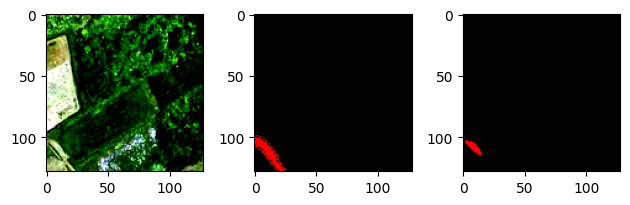

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1246682..2.378562].


============================== 1373 ==============================
/work/GSI_Dataset/org286/8722.png


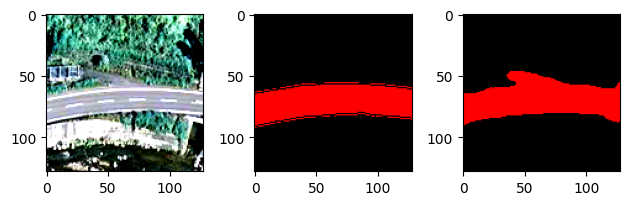

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6384108..2.64].


============================== 1758 ==============================
/work/GSI_Dataset/org286/2724.png


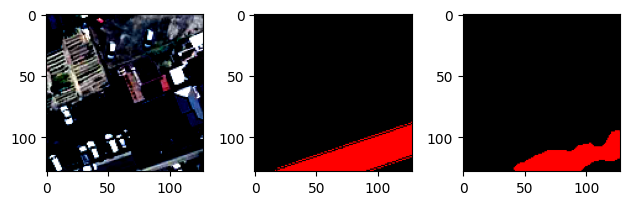

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3644148..2.465708].


============================== 878 ==============================
/work/GSI_Dataset/org286/279.png


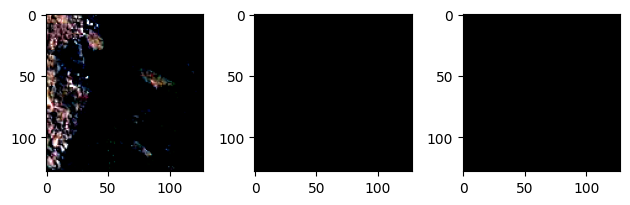

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1247059..2.2146587].


============================== 838 ==============================
/work/GSI_Dataset/org286/6722.png


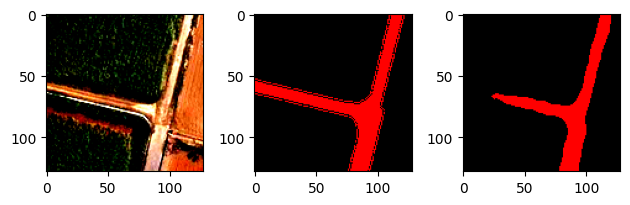

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..2.64].


============================== 939 ==============================
/work/GSI_Dataset/org286/6465.png


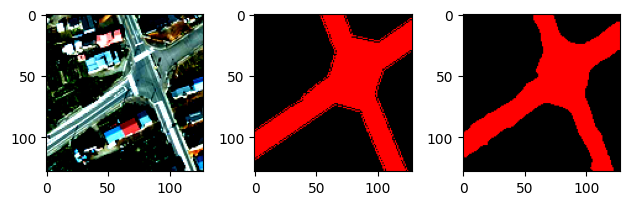

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4842881..1.9951198].


============================== 748 ==============================
/work/GSI_Dataset/org286/2729.png


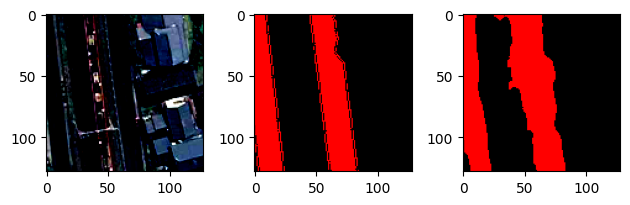

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8431373..0.005565545].


============================== 1070 ==============================
/work/GSI_Dataset/org286/638.png


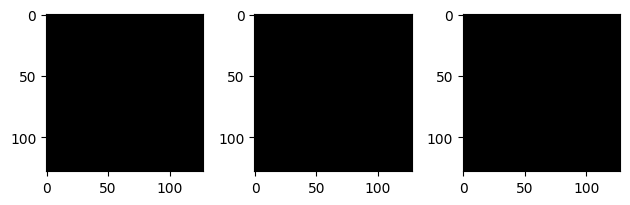

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4842881..2.64].


============================== 1262 ==============================
/work/GSI_Dataset/org286/9925.png


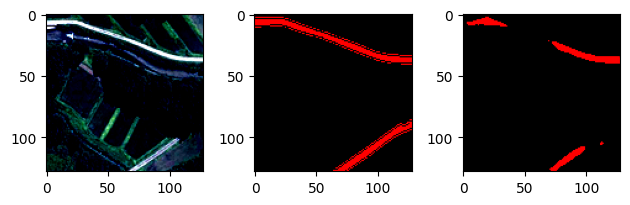

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582841..2.64].


============================== 872 ==============================
/work/GSI_Dataset/org286/2665.png


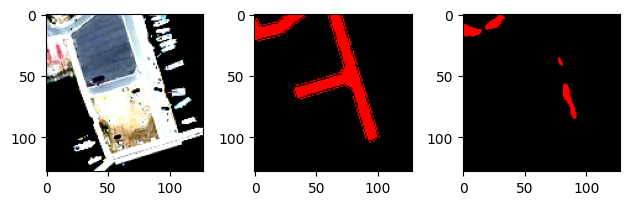

In [13]:
list_length = len(data_info["val_dataset"])
indices = random.sample(range(list_length), 10)

for idx in indices:
    print("="*30 , idx, "="*30)
    print(data_info["val_img_path"][idx])
    check_prediction(idx)